In [19]:
from pathlib import Path

import numpy as np
import pyvista as pv
from IPython.display import Image
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.metrics import r2_score
import statsmodels.api as sm

import polpo.preprocessing.pd as ppd
from polpo.models import ObjectRegressor
from polpo.preprocessing import IndexMap, NestingSwapper, PartiallyInitializedStep
from polpo.preprocessing.dict import DictMap, DictMerger
from polpo.preprocessing.load.pregnancy import (
    DenseMaternalCsvDataLoader,
    DenseMaternalMeshLoader,
)
from polpo.preprocessing.mesh.io import PvReader
from polpo.preprocessing.mesh.registration import PvAlign
from polpo.sklearn.adapter import AdapterPipeline
from polpo.sklearn.mesh import InvertibleMeshesToVertices
from polpo.sklearn.np import InvertibleFlattenButFirst

In [20]:
n_components = [4,]# 6, 9]
structs = ["Hipp", "Amyg"]

In [23]:
prep_pipe = PartiallyInitializedStep(
    Step=lambda **kwargs: DictMap(PvAlign(**kwargs)),
    _target=lambda meshes: meshes[list(meshes.keys())[0]],
    max_iterations=500,
)

subject_id = "01"

file_finder = DenseMaternalMeshLoader(
    # data_dir="~/.herbrain/data/pregnancy/czi_data_1st_upload_hggm",
    subject_id=subject_id,
    as_dict=True,
    left=True,
    struct=structs[0],
)

pipe = file_finder + DictMap(PvReader()) + prep_pipe

meshes = pipe()
# meshes

In [24]:
pilot = subject_id == "01"

pipe = DenseMaternalCsvDataLoader(pilot=pilot, subject_id=subject_id)

df = pipe()

session_selector = ppd.DfIsInFilter("stage", ["post"], negation=True)

predictor_selector = (
    session_selector + ppd.ColumnsSelector("gestWeek") + ppd.SeriesToDict()
)

x_dict = predictor_selector(df)

for struct in structs:
    for n in n_components:
        pca = PCA(n_components=n)

        objs2y = AdapterPipeline(
            steps=[
                FunctionTransformer(func=np.squeeze),  # undo sklearn 2d
                InvertibleMeshesToVertices(index=0),
                FunctionTransformer(func=np.stack),
                InvertibleFlattenButFirst(),
                StandardScaler(with_std=False),
                pca,
            ],
        )

        dataset_pipe = (
            DictMerger() + NestingSwapper() + IndexMap(lambda x: np.array(x)[:, None], index=0)
        )
        
        X, meshes_ = dataset_pipe((x_dict, meshes))
        print(X)
        
        objs2y.fit(meshes_)
        
        model = ObjectRegressor(LinearRegression(fit_intercept=True), objs2y=objs2y)
        
        y_pca = objs2y.transform(meshes_)
        y_pca, y_pca.shape
        
        # print(X)
        reg = LinearRegression().fit(X, y_pca)
        # reg
        
        X_pred = np.linspace(-3, 42, num=19)[:, None]
        
        y_pca_pred = reg.predict(X_pred)
        
        numerator = np.sum((y_pca - y_pca_pred)**2)
        denominator = np.sum((y_pca - np.mean(y_pca))**2)
        r2_global = 1 - numerator / denominator
        print(f"Global R² across all PCs for struct {struct} and {n} components: {r2_global}")
        
        time = np.arange(len(meshes_))[:, None]  

        regressors = []
        r2_scores = []
        p_values = []
        
        for i in range(y_pca.shape[1]):
            y = y_pca[:, i]
            X_sm = sm.add_constant(time)  
            model = sm.OLS(y, X_sm).fit()
            
            regressors.append(model)
            r2_scores.append(model.rsquared)
            p_values.append(model.pvalues[1])  # p-value for the slope
        
        # print R2 and p-values for each PC
        for i, (r2, p) in enumerate(zip(r2_scores, p_values)):
            print(f"\tPC {i+1}: R² = {r2:.4f}, p = {p:.4f}")
        
        # predict PCs at new timepoints
        X_pred = np.linspace(-3, 42, num=10)[:, None]
        predicted_pcs = np.column_stack([model.predict(sm.add_constant(X_pred)) for model in regressors])  # shape (10, 4)
        

INFO: Data has already been downloaded... using cached file ('/Users/sak/.herbrain/data/maternal/28Baby_Hormones.csv').


[[-3. ]
 [-0.5]
 [ 1. ]
 [ 1.5]
 [ 2. ]
 [ 3. ]
 [ 9. ]
 [12. ]
 [14. ]
 [15. ]
 [17. ]
 [19. ]
 [22. ]
 [24. ]
 [27. ]
 [29. ]
 [31. ]
 [33. ]
 [36. ]]
Global R² across all PCs for struct Hipp and 4 components: 0.06460653637284586
	PC 1: R² = 0.0676, p = 0.2824
	PC 2: R² = 0.0046, p = 0.7823
	PC 3: R² = 0.2415, p = 0.0326
	PC 4: R² = 0.0049, p = 0.7756
[[-3. ]
 [-0.5]
 [ 1. ]
 [ 1.5]
 [ 2. ]
 [ 3. ]
 [ 9. ]
 [12. ]
 [14. ]
 [15. ]
 [17. ]
 [19. ]
 [22. ]
 [24. ]
 [27. ]
 [29. ]
 [31. ]
 [33. ]
 [36. ]]
Global R² across all PCs for struct Amyg and 4 components: 0.06460650107595278
	PC 1: R² = 0.0676, p = 0.2824
	PC 2: R² = 0.0046, p = 0.7823
	PC 3: R² = 0.2415, p = 0.0326
	PC 4: R² = 0.0049, p = 0.7756


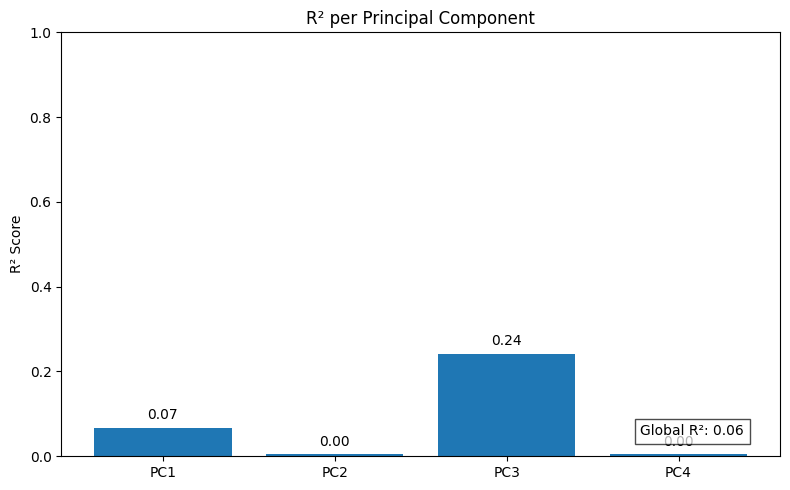

In [15]:
import matplotlib.pyplot as plt

# Let's say you have:
# r2_scores = [r2_pc1, r2_pc2, r2_pc3, r2_pc4] from earlier
# r2_global = global R² score from flattening everything

pc_labels = [f"PC{i+1}" for i in range(len(r2_scores))]

plt.figure(figsize=(8, 5))
bars = plt.bar(pc_labels, r2_scores)

plt.title("R² per Principal Component")
plt.ylabel("R² Score")
plt.ylim(0, 1)

# Annotate bars
for bar, score in zip(bars, r2_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f"{score:.2f}", ha='center')

# Show global R² in title or as a text box
plt.gca().text(0.95, 0.05, f"Global R²: {r2_global:.2f}",
               transform=plt.gca().transAxes, ha='right', bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

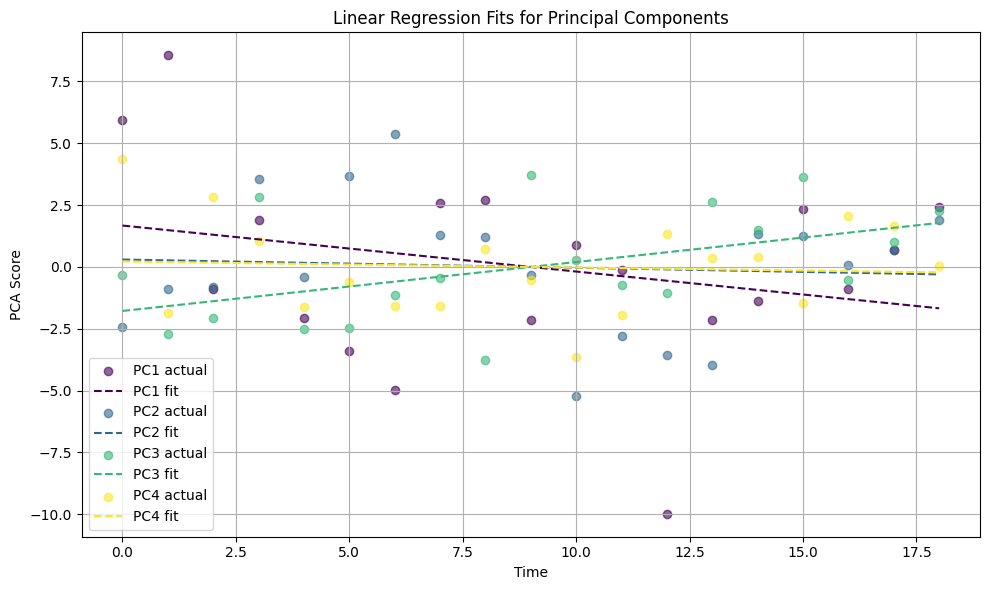

In [16]:
n_components = y_pca.shape[1]
colors = plt.cm.viridis(np.linspace(0, 1, n_components))

plt.figure(figsize=(10, 6))

for i in range(n_components):
    # Plot actual PC values
    plt.scatter(time, y_pca[:, i], label=f"PC{i+1} actual", color=colors[i], alpha=0.6)
    
    # Plot regression line
    t_line = np.linspace(time.min(), time.max(), 100)[:, None]
    t_line_with_const = sm.add_constant(t_line)  # Adds intercept column
    
    y_line = regressors[i].predict(t_line_with_const)
    plt.plot(t_line, y_line, color=colors[i], linestyle="--", label=f"PC{i+1} fit")

plt.title("Linear Regression Fits for Principal Components")
plt.xlabel("Time")
plt.ylabel("PCA Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()